In [1]:
# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings

In [2]:
#3D 데이터셋

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# SVD 분해를 통한 PCA

In [9]:
X_centered = X - X.mean(axis=0)
#linalg - linear algebra(선형 대수)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

#첫번째 주성분 c1, 두번째 주성분 c2
c1, c2

(array([0.93636116, 0.29854881, 0.18465208]),
 array([-0.34027485,  0.90119108,  0.2684542 ]))

In [10]:
#첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [11]:
X2D_using_svd = X2D

# 사이킷런을 사용한 PCA

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [13]:
X2D_using_svd[:5] #직접 구한것과 사이킷런 PCA를 통해 구한것의 비교

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [14]:
np.allclose(X2D, -X2D_using_svd)

True

In [15]:
# 평면(PCA 2D 부분공간)에 투영된 3D포인트를 복원

X3D_inv = pca.inverse_transform(X2D)

#투영 단계에서 일부 정보를 잃어버리므로 원본 3D 포인트와 완전히 같지는 않음
np.allclose(X3D_inv, X)

False

In [18]:
#PCA의 주성분 참조

pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [20]:
#분산 비율에 대한 설명 확인
pca.explained_variance_ratio_, 1 - pca.explained_variance_ratio_.sum()

(array([0.84248607, 0.14631839]), 0.011195535570688975)

첫 번째 차원이 84.2%의 분산을 포함하고 있고, 두번째는 14.6%의 분산을 포함하고 있음.

3d->2d로 투영했기 때문에 분산의 1.1%를 잃었음

In [21]:
#3D 화살표를 그리기 위한 클래스
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [24]:
#x와 y의 함수로 평면을 표현

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

x1.shape, x2.shape, C.shape, R.shape, z.shape

((10, 10), (10, 10), (2, 3), (3, 3), (10, 10))

그림 저장 dataset_3d_plot


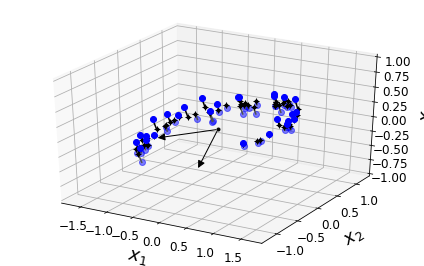

In [26]:
#3D데이터셋, 평면 그리고 이 평면으로의 투영 그리기
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]] #투영 평면 위에 있는 점들
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]] #투영 평면 밑에 있는 점들

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5) #투영 평면 밑의 점들 그리고

ax.plot_surface(x1, x2, z, alpha=0.2, color="k") #투영 평면 그리기
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: 맷플롯립 3.0.0 버전은 버그가 있기 때문에
# 3D 그래프를 잘 출력하지 못합니다.
# https://github.com/matplotlib/matplotlib/issues/12239 를 참조하세요.
# 따라서 최신 버전으로 업그레이드해야 합니다.
# 만약 업그레이드할 수 없다면 3D 그래프를 그리기 전에 다음 코드를 실행하세요:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

그림 저장 dataset_2d_plot


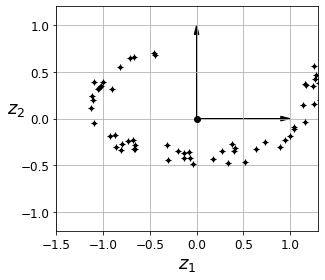

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

# 축소할 차원 수 선택하기(MNIST)

In [30]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)#문자를 숫자로 변환

In [31]:
from sklearn.model_selection import train_test_split

X = mnist.data
y = mnist.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
#차원을 축소하지 않고 PCA 계산뒤, 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수 계산

pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_) #각 주성분에 대한 분산 비율을 앞에서 부터 뒤로 더하면서 누적시킨다.

d = np.argmax(cumsum >= 0.95) + 1 #누적된 분산이 95%를 넘는 첫 인덱스에 1을 더한 값을 구하면,

#그 값이 분산이 95%이상 되기 위한 최소의 차원 개수

d, pca.explained_variance_ratio_.shape, cumsum.shape, pca.explained_variance_ratio_[:10], cumsum[:10]

(154,
 (784,),
 (784,),
 array([0.09751219, 0.07163911, 0.06188164, 0.05382775, 0.04898059,
        0.04315101, 0.03270144, 0.028851  , 0.02752413, 0.0233792 ]),
 array([0.09751219, 0.1691513 , 0.23103295, 0.2848607 , 0.3338413 ,
        0.3769923 , 0.40969374, 0.43854475, 0.46606888, 0.48944808]))

그림 저장 explained_variance_plot


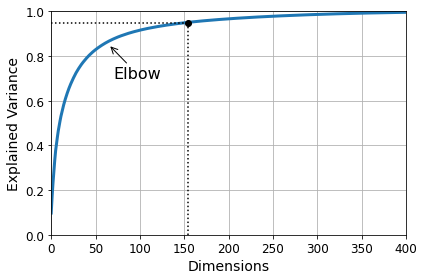

In [38]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70,0.7), arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [40]:
#사이킷런 PCA를 통해 구하기(95% 분산을 가지는 차원 개수를 구하도록 설정), 물론 직접 개수를 입력할 수도 있음
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

pca.n_components_, np.sum(pca.explained_variance_ratio_)

(154, 0.9504326468621527)

In [48]:
X_recovered = pca.inverse_transform(X_reduced)

In [42]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장 mnist_compression_plot


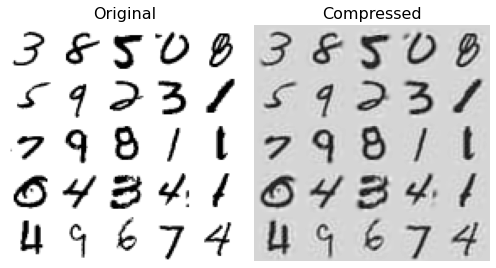

In [49]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
#X_train의 전체 데이터에 대해서 2100개씩 건너뛰면서 선택 -> 25개 이미지 데이터
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)

plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

# 점진적 PCA

SVD알고리즘을 위해서 전체 훈련 세트를 메모리에 올려야 하는데, 미니배치를 통해 PCA를 사용하는 점진적 PCA가 있음

In [51]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154) #전체 PCA처럼 비율을 입력할 수 없음
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

inc_pca.components_

array([[-2.22044605e-16, -4.33680869e-18, -9.86623977e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.30753523e-16, -1.90125693e-15, -2.34534614e-15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.29976931e-16, -4.02455846e-16,  9.43689571e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 6.90203103e-16,  2.63677968e-16,  8.18789481e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.10641985e-15, -1.21430643e-17, -7.63278329e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.82219406e-17, -1.74860126e-15, -6.83481050e-16, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]])

In [52]:
inc_pca.components_.shape

(154, 784)

In [53]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Compressed Inc PCA')

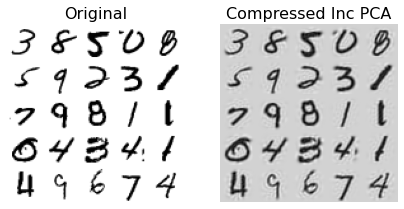

In [54]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
#X_train의 전체 데이터에 대해서 2100개씩 건너뛰면서 선택 -> 25개 이미지 데이터
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)

plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.title("Compressed Inc PCA", fontsize=16)

점진적 PCA는 훌륭한 근사치를 제공하지만 완벽하지는 않다

# memmap() 사용하기

하드디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어 있는 것 처럼 다루기

In [55]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype="float32", mode="write", shape=(m, n)) #memmap생성
X_mm[:] = X_train #데이터 복사

In [56]:
#디스크에 저장 확인을 위해 memmap() 객체 삭제
del X_mm

In [57]:
#다른 프로그램에서 데이터를 로드하여 훈련에 사용
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

# 커널 PCA

SVM에서 여러 차원을 늘린 것 처럼 활용하던 커널 트릭을 활용

In [67]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [59]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

그림 저장 kernel_pca_plot


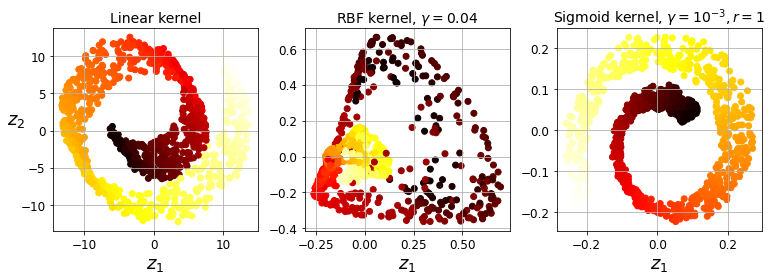

In [60]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

In [61]:
#커널 선택과 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [
    {
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }
]

grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [62]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

# LLE(지역 선형 임베딩)

투영에 의존하지 않는 매니폴드 학습, 비선형 차원축소(NLDR)기술

In [70]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [71]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

그림 저장 lle_unrolling_plot


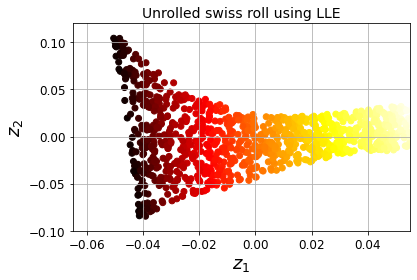

In [72]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

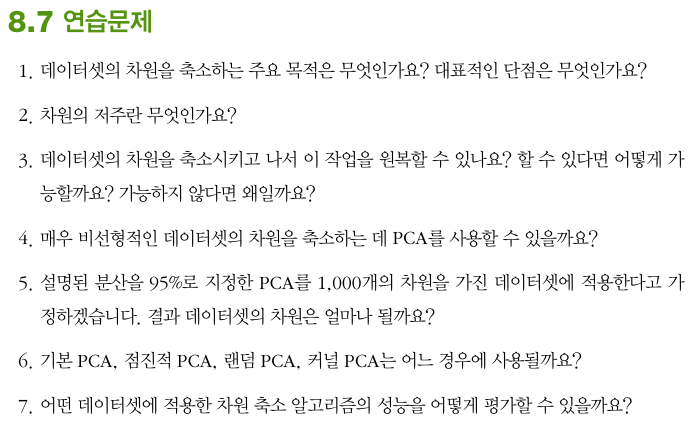
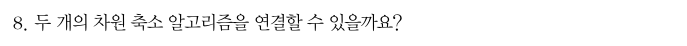

1. 차원 축소의 목적
   - 훈련 알고리즘의 속도를 높이기 위해
   - 데이터 시각화 및 가장 중요한 특성에 대한 통찰을 얻기 위해
   - 메모리 공간을 절약하기 위해(압축)

  주요 단점
   - 일부 정보를 읽어버려 훈련 알고리즘의 성능을 떨어뜨릴 수 있음
   - 계산 비용이 높음
   - 머신러닝 파이프라인의 복잡도 증가
   - 변환된 데이터를 이해하기 어려운 경우가 많음


2. 저차원 공간에는 없는 많은 문제가 고차원에 발생  
   머신러닝에서 무작위로 선택한 고차원 벡터는 매우 희소하기 때문에 과대적합의 위험이 크고  
   많은 양이 데이터가 있지 않으면 데이터의 패턴을 찾기 어려움
   
   
3. 데이터셋의 차원이 축소되면서 일부 정보가 소실되므로 완벽한 복원은 불가능. PCA 알고리즘들은 간단한 역변환 제공


4. PCA는 불필요한 차원을 제거할 수 있으므로 매우 비선형적이라도 사용할 수 있음. 그러나 스위스 롤 같이 불필요한 차원이 없다면 PCA의 차원 축소는 너무 많은 정보를 잃게 만듬


5. 만약 거의 완벽하게 일렬로 늘어선 데이터 셋이라면 차원을 1개로 줄일 수 있고, 완전한 무작위로 1000개의 차원에 흝어져있다면 거의 950개 차원이 필요. 분산 그래프를 그려보는 것이 좋음


6. 기본 PCA가 우선적으로 사용됨, 메모리가 한정적일 때는 점진적 PCA(하지만 느림)  
   랜덤PCA는 데이터셋이 메모리 크기에 맞고 차원을 크게 축소시킬때
   커널PCA는 비선형 데이터섯에 유용
   
   
7. 많은 정보를 잃지않고 차원을 제거할 수 있다면 우수한 성능.  
   역변환을 통해 재구성 오차를 측정하는 것.  
   혹은 원본 데이터셋과 축소된 데이터 셋의 성능 비교
   
   
8. 연결 가능. PCA로 불필요한 차원을 대폭 제거하고 LLE같은 훨씬 느린 알고리즘을 적용하는 것이 대표적

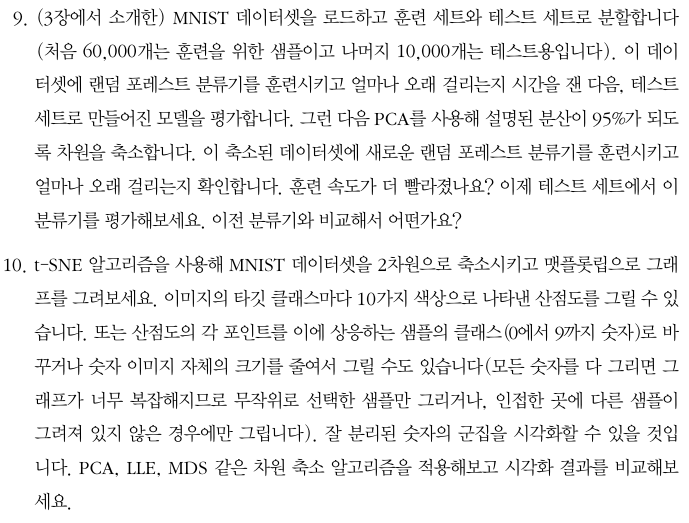

In [74]:
#연습 문제 9

X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

In [75]:
#랜덤 포레스트 분류기 훈련, 테스트 세트로 모델 평가
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [76]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

print("훈련 시간: {:.2f}초".format(t1 - t0))

훈련 시간: 6.06


In [78]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [79]:
#PCA를 통해 분산이 95%가 되도록 차원을 축소

from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [80]:
#축소된 데이터셋에 대해 훈련 시간 측정

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

t0 = time.time()
rnd_clf.fit(X_train_reduced, y_train)
t1 = time.time()

print("훈련 시간: {:.2f}초".format(t1 - t0))

훈련 시간: 11.76초


훈련 시간이 두 배 정도 늘어남.

차원축소가 항상 훈련 시간을 줄여주지는 못한다.

훈련 알고리즘에 따라 다른데, 랜덤 포레스트 대신 소프트맥스 분류를 사용하면 시간을 확 줄일 수 있다.

In [81]:
#축소된 데이터셋에 대한 정확도 측정
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

차원 축소 과정에서 유용한 정보를 잃어버러 정확도가 떨어졌다.

이 경우 PCA는 도움이 되지 않음

In [83]:
#소프트맥스 회귀로 확인

from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

print("훈련 시간: {:.2f}초".format(t1 - t0))

훈련 시간: 11.18초


c:\sources\python\deeplearning\dl\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [84]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [85]:
#축소된 데이터셋에 대해 소프트 맥스

log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print("훈련 시간: {:.2f}초".format(t1 - t0))

훈련 시간: 4.23초


c:\sources\python\deeplearning\dl\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


차원 축소를 통해 속도가 3배 정도 빨라짐.

모델 정확도 확인

In [87]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

큰 성능의 저하 없이 훈련 속도 향상.

PCA는 항상 빠른 결과가 나오는 것은 아니다.

In [88]:
#연습 문제 10

#속도를 위해 10000개의 이미지만 무작위로 선택
m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist.data[idx]
y = mnist.target[idx]

In [89]:
#t-SNE로 2차원 축소

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_reduced = tsne.fit_transform(X)

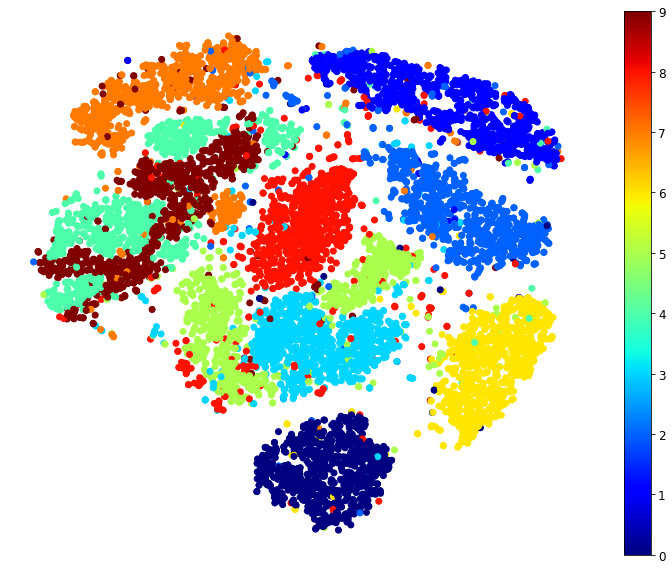

In [90]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis("off")
plt.colorbar()
plt.show()

4, 9, 5, 3이 서로 뒤섞여 구분하기 어려움을 알 수 있음

많이 겹쳐진 4, 9, 7에 집중

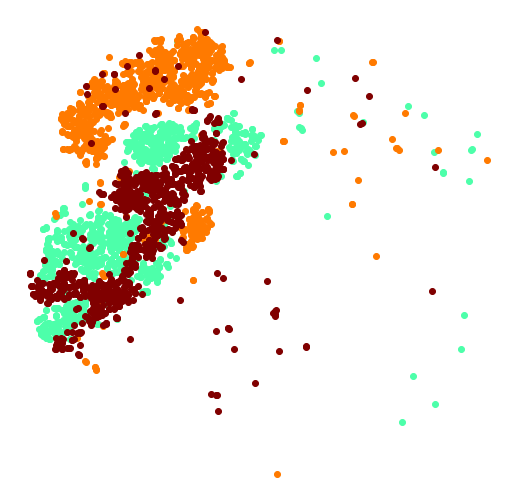

In [91]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (4, 7, 9):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

In [92]:
# 3개의 숫자에 t-SNE 실행해서 확인

idx = (y == 4) | (y == 7) | (y == 9)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

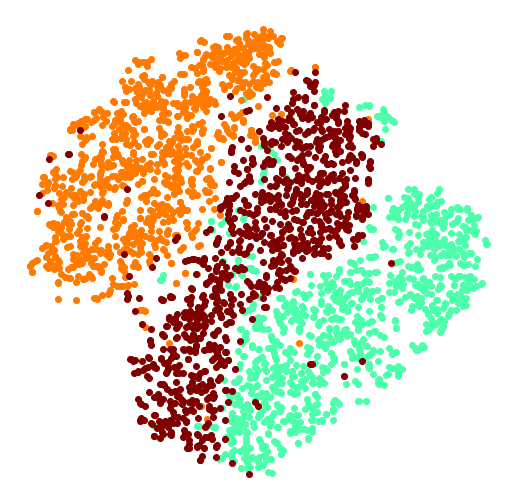

In [95]:
plt.figure(figsize=(9,9))
for digit in (4, 7, 9):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

군집이 훨씬 덜 겹쳐졌다.

9가 여러 군데에 흩어져 있고,

4는 군집이 2개처럼 보인다.

In [96]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # 입력 특성의 스케일을 0에서 1 사이로 만듭니다.
    X_normalized = MinMaxScaler().fit_transform(X)
    # 그릴 숫자의 좌표 목록을 만듭니다.
    # 반복문 아래에서 `if` 문장을 쓰지 않기 위해 시작할 때 이미 그래프가 그려져 있다고 가정합니다.
    neighbors = np.array([[10., 10.]])
    # 나머지는 이해하기 쉽습니다.
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # 현재 그래프의 축을 가져옵니다.
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

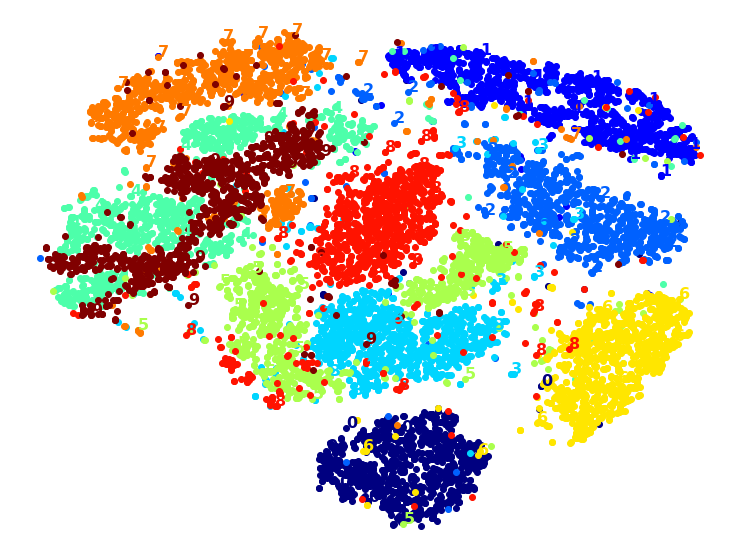

In [97]:
#색깔이 입혀진 숫자
plot_digits(X_reduced, y)

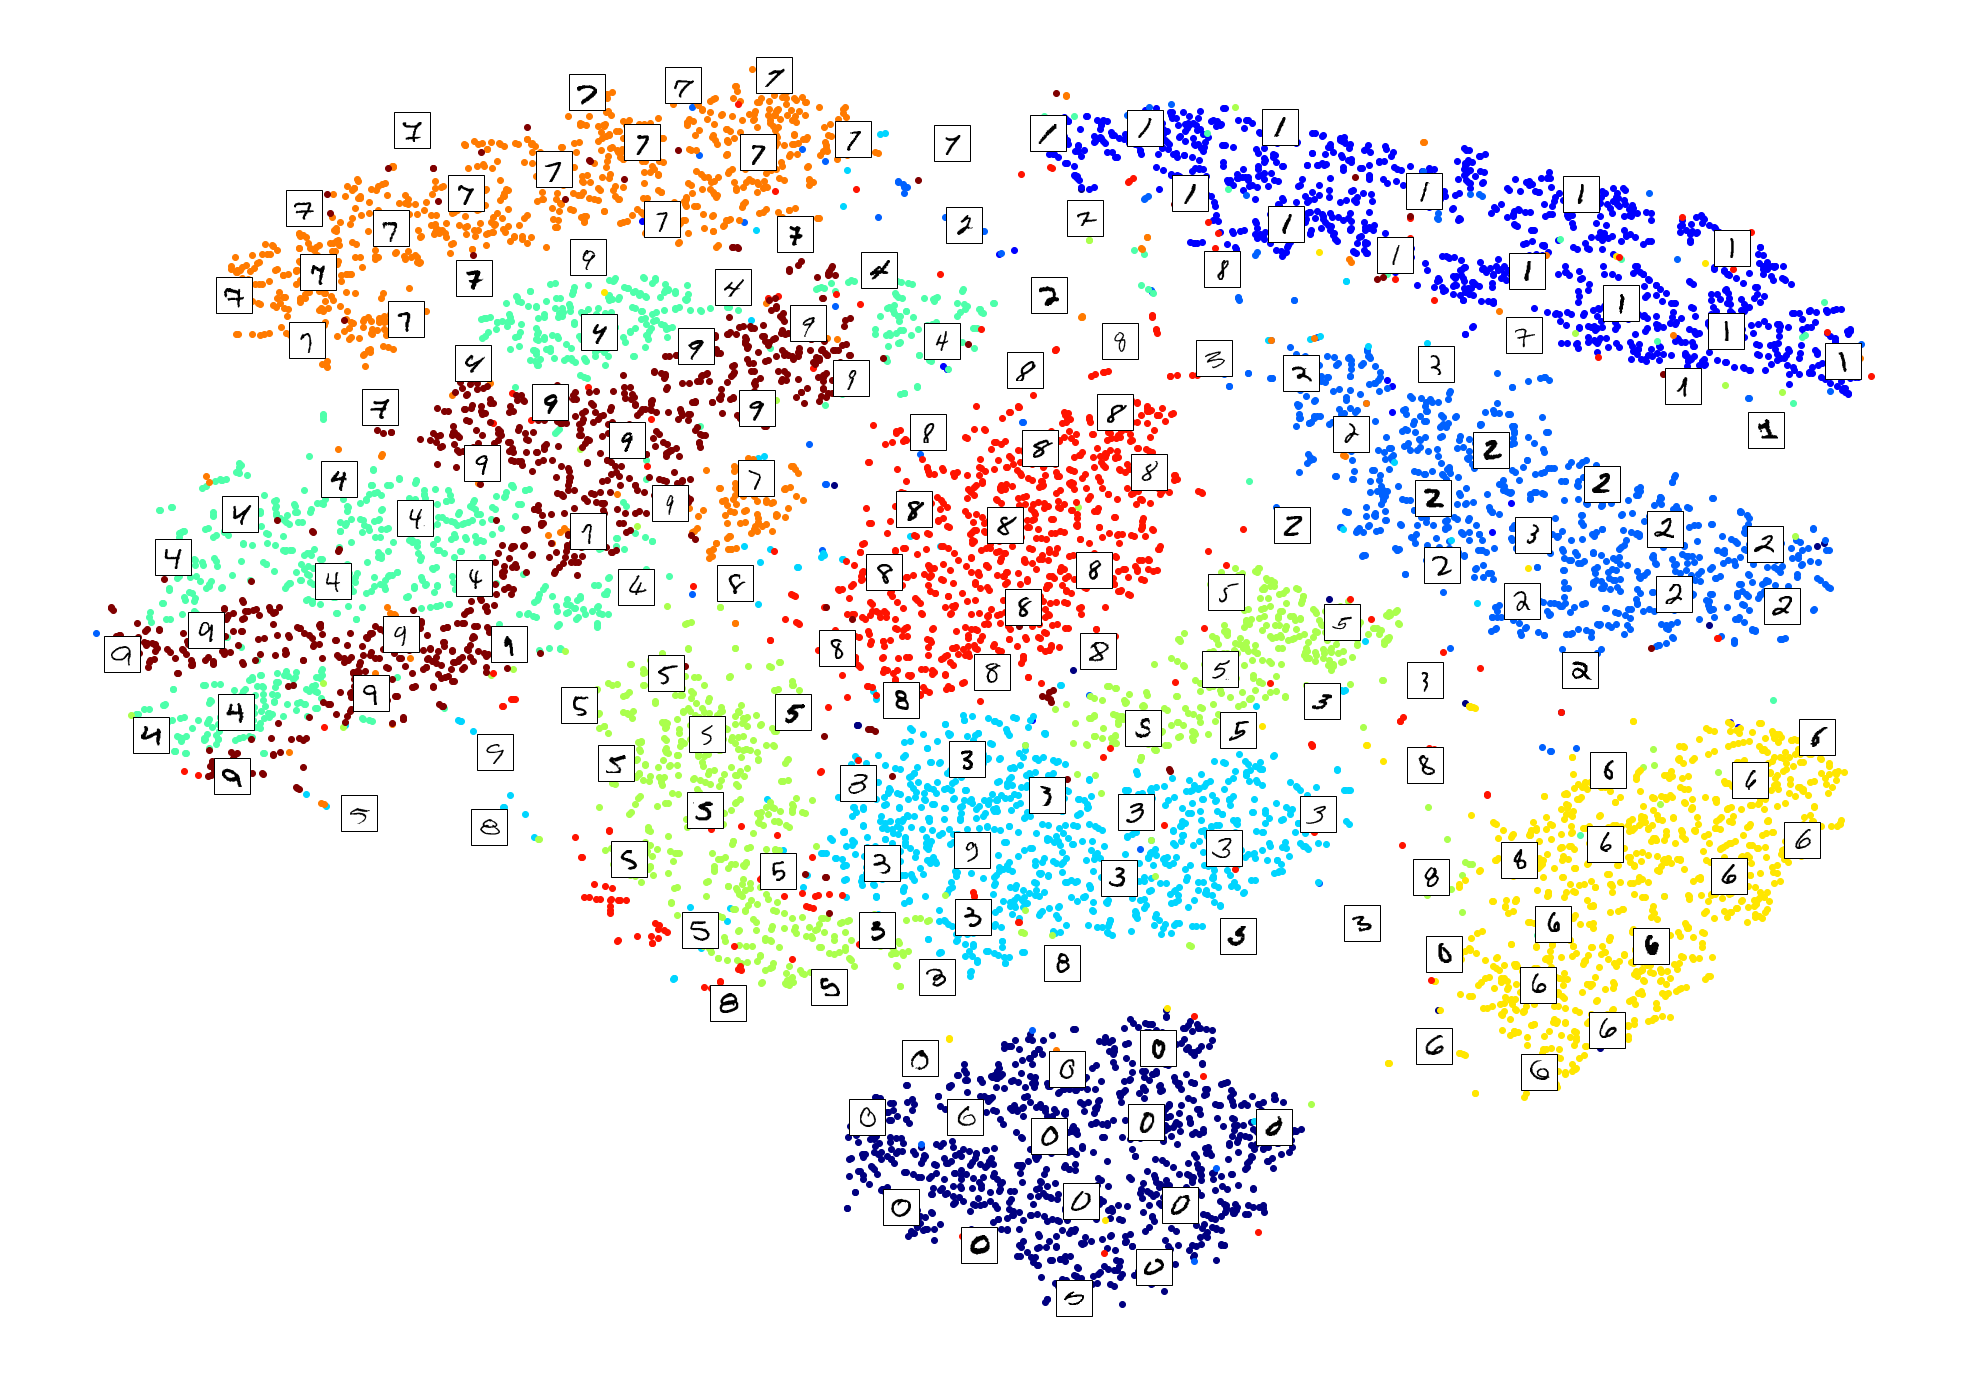

In [98]:
#숫자 이미지 사용
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

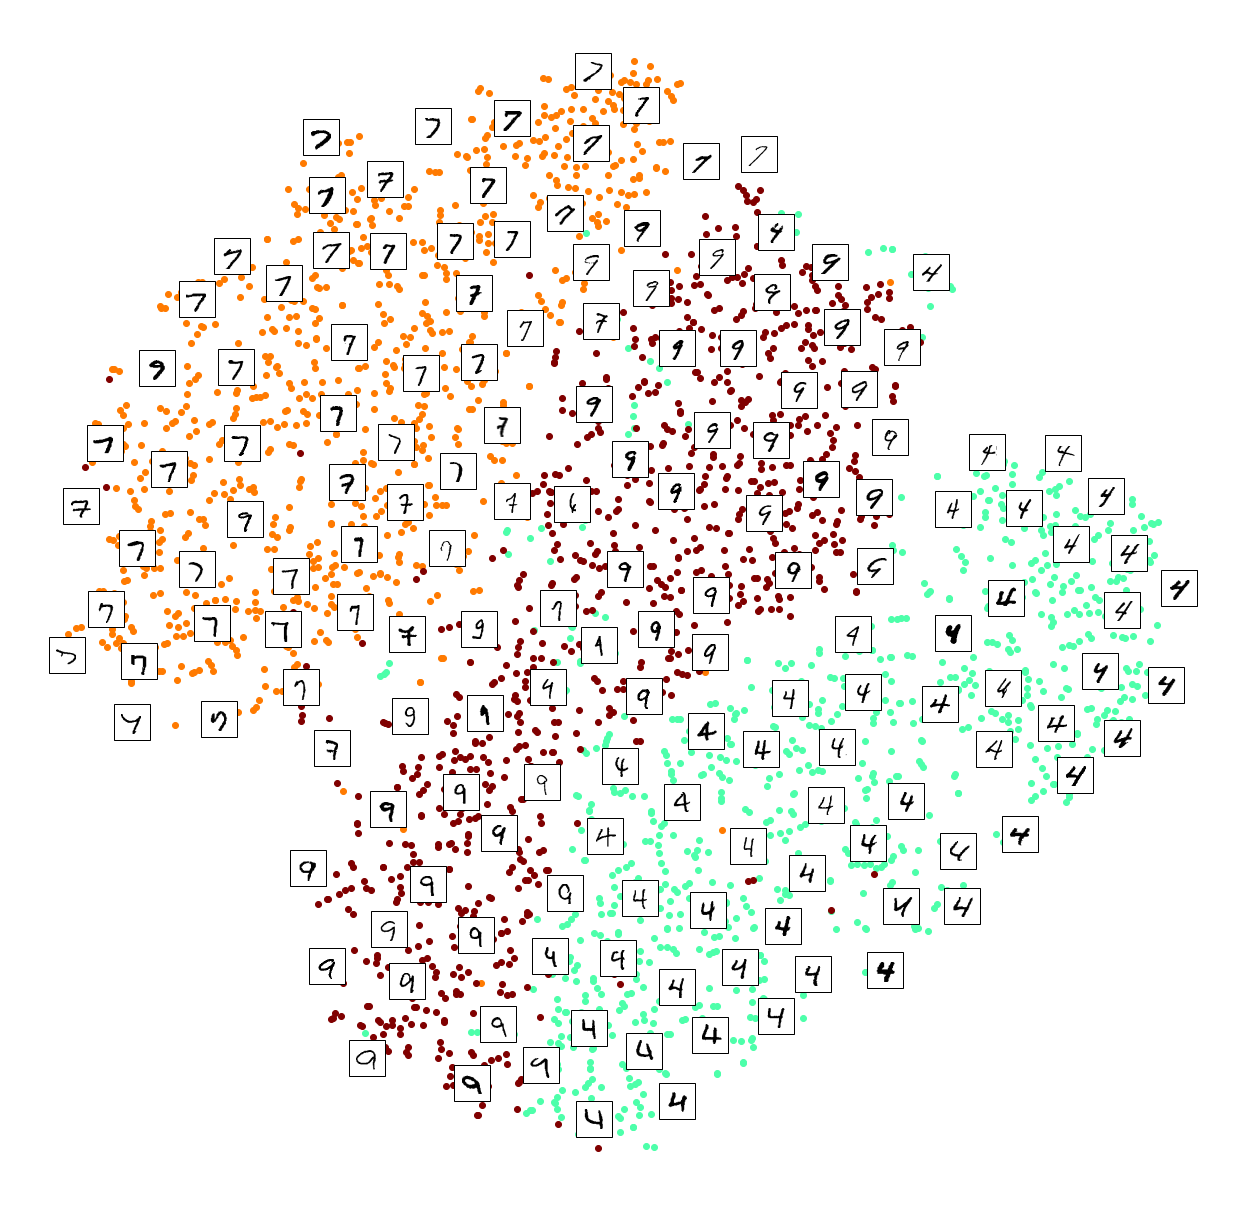

In [99]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

PCA, LLE, MDS 등 차원 축소 알고리즘을 적용해보고 시각화 결과를 비교

PCA 시간: 0.2s.


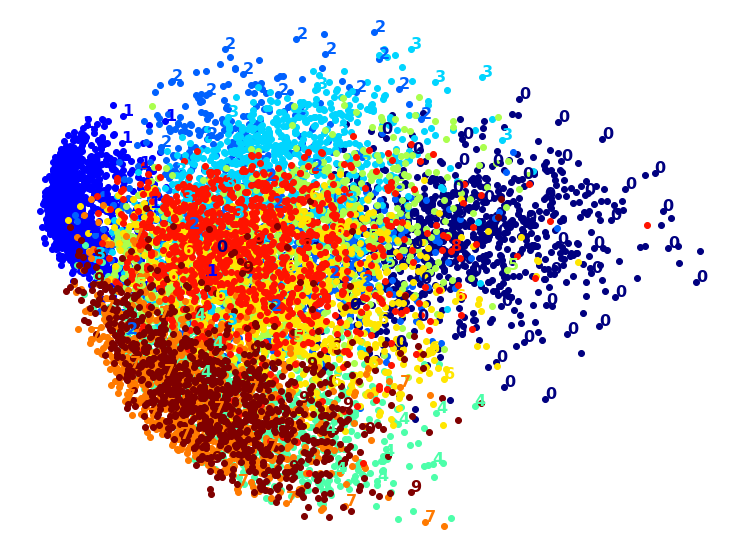

In [100]:
#PCA

from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

너무 겹쳐서 잘 안보인다. LLE를 테스트

LLE 시간: 66.7s.


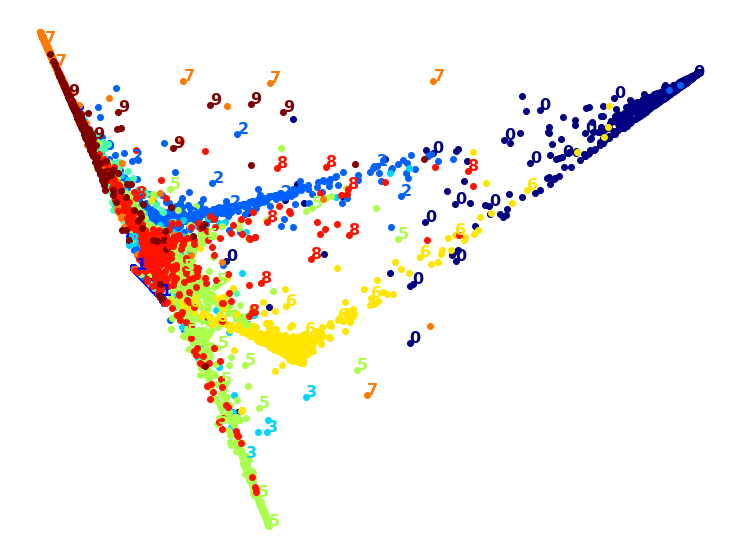

In [101]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42, n_jobs=-1).fit_transform(X)
t1 = time.time()
print("LLE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

시간도 걸리고 결과도 잘 보이지 않는다.

PCA를 통해 분산 95%를 보존하도록 처리 후 LLE를 실행

PCA+LLE 시간: 56.5s.


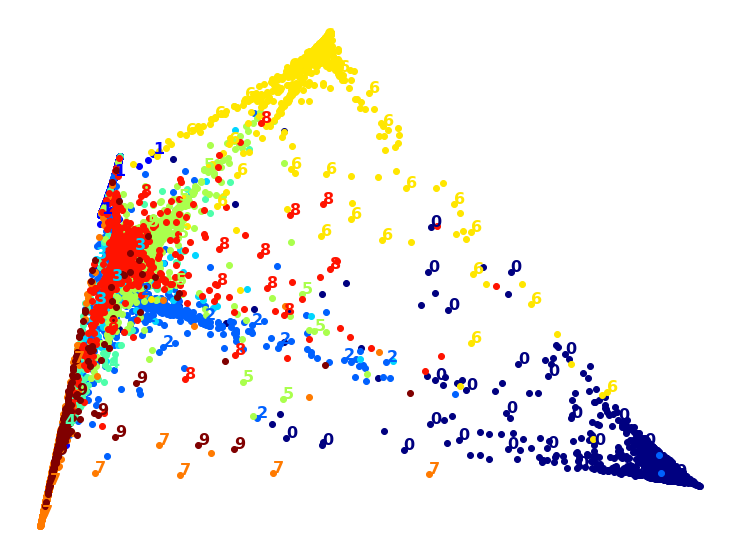

In [103]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42, n_jobs=-1)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

시간이 좀 줄었다.

MDS는 너무 오래걸리므로 2000개만 시도

MDS 시간 56.1s (on just 2,000 MNIST images instead of 10,000).


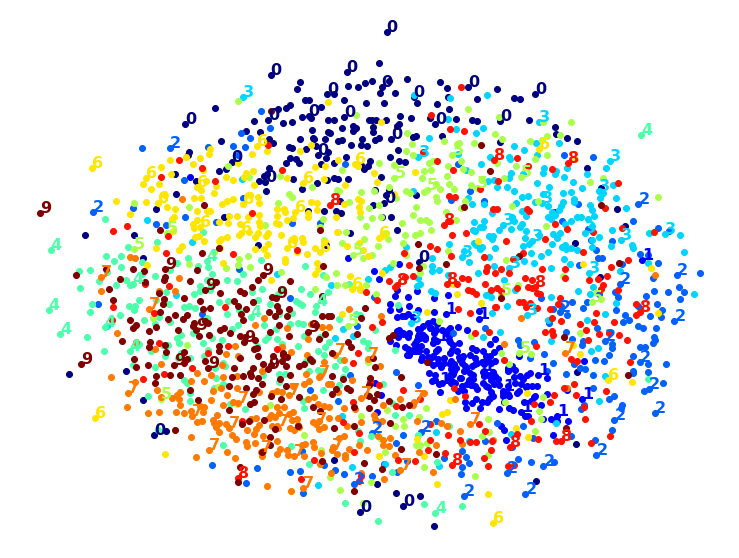

In [104]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42, n_jobs=-1).fit_transform(X[:m])
t1 = time.time()
print("MDS 시간 {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

군집이 너무 겹쳐 보인다. PCA를 먼저 적용

PCA+MDS 시간 55.8s (on 2,000 MNIST images).


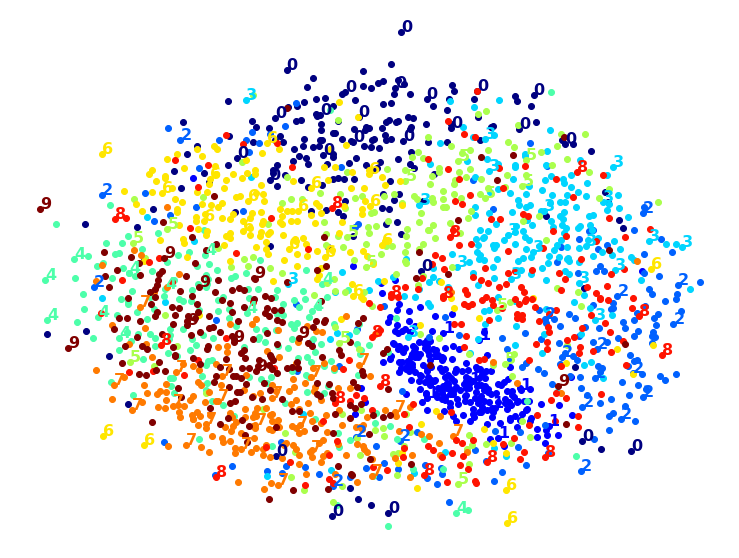

In [105]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42, n_jobs=-1)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS 시간 {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

시간도 별 차이없고 결과물도 비슷

LDS를 시도

LDA 시간 1.8s.


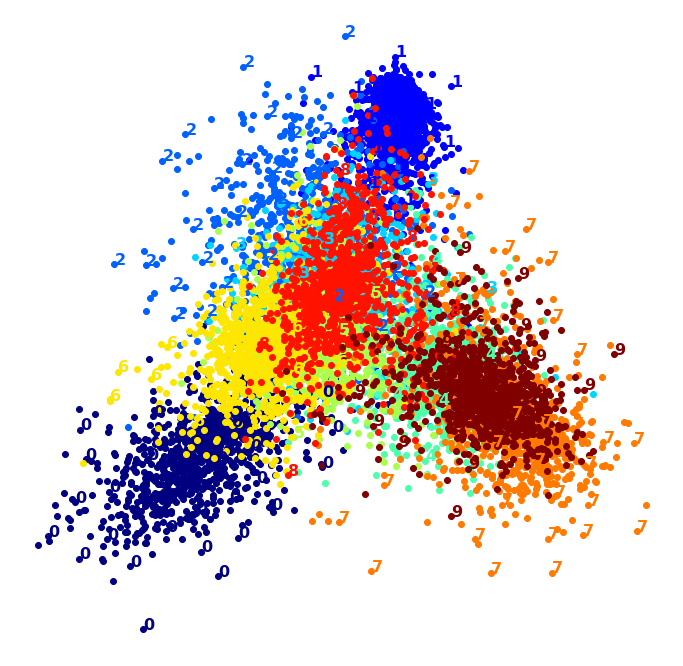

In [106]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

빠르긴 하지만, 군집이 많이 겹쳐있다.

t-SNE가 가장 좋은 결과를 보인다.

시간을 측정

t-SNE 시간 47.7s.


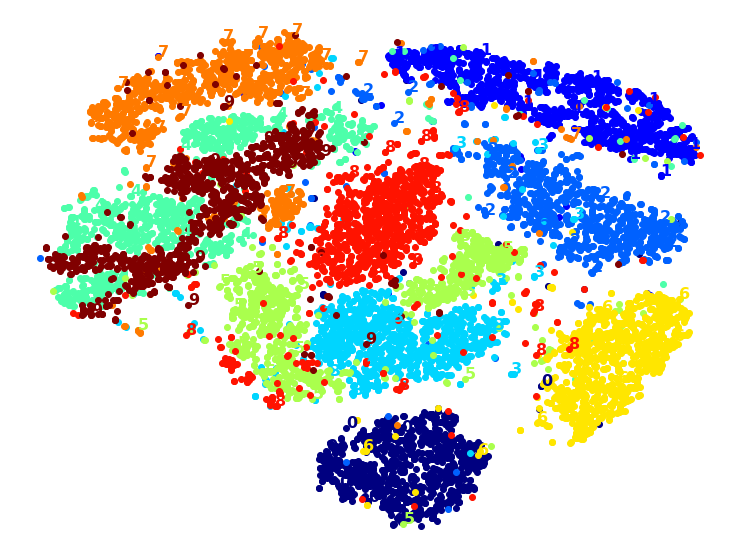

In [107]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42, n_jobs=-1).fit_transform(X)
t1 = time.time()
print("t-SNE 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

멀티 코어 적용시 LLE보다 빠르고 MDS보다 도 빠름

PCA 적용 확인

PCA+t-SNE 시간 35.0s.


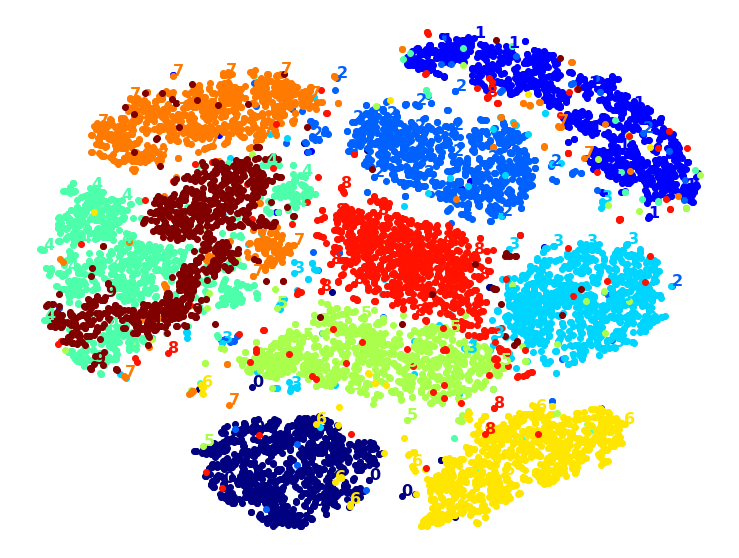

In [108]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42, n_jobs=-1)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

결과물에 큰 차이가 없으면서 시간이 단축되었음. 이 조합이 제일 우수